TN Farm News Title and Publishing Date Metadata Automation

In [30]:
%matplotlib inline
from pathlib import Path
from shutil import copy

import cv2
import numpy as np
import pandas as pd
import pytesseract
from fuzzywuzzy import fuzz, process
from ipywidgets import IntProgress, Label, VBox
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image
from skimage.measure import compare_ssim as ssim

import img_qc.img_qc as img_qc

plt.rc('figure', figsize=(20.0, 10.0))

In [93]:
def bgr_imshow(bgr_image):
    bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    plt.imshow(bgr_image)
    plt.show()

    
def crop_image_for_ocr(image_path, percentage=0.4, top_and_sides_padding=25):
    
    # load image and get shape
    image = cv2.imread(str(image_path))
    height, width = image.shape[:2]
    
    # set (x, y) pairs
    x1, y1, x2, y2 = 0, 0, width, int(height * percentage)
    
    # add/subtract padding from the top/left/right 
    x1 += top_and_sides_padding
    y1 += top_and_sides_padding
    x2 -= top_and_sides_padding
    # add image area to the bottom that was cropped from the top
    y2 += top_and_sides_padding
    
    # crop image
    image = image[y1:y2, x1:x2]
    
    return image


# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
def find_crop(image_search_for, image_look_in, minimum_matches, distance_ratio):

    image_search_for = np.array(image_search_for)
    image_look_in = np.array(image_look_in)

    # convert to grayscale if necessary
    image_search_for_gray = if_rgb_convert_to_gray(image_search_for)
    image_look_in_gray = if_rgb_convert_to_gray(image_look_in)
    
    # equalize histogram of image we're looking in (already done for title crop)
    # image_look_in_gray = cv2.equalizeHist(image_look_in_gray)
    # image_search_for_gray = cv2.equalizeHist(image_search_for_gray)

    # create SIFT object
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find keypoints and descriptors with SIFT
    keypoints_1, descriptors_1 = sift.detectAndCompute(image_search_for_gray, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_look_in_gray, None)
    
    FLANN_INDEX_KDTREE = 0
    index_parameters = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_parameters = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_parameters, search_parameters)
    
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append(m)
    number_of_good_matches = len(good_matches)
    # print(f'before: {number_of_good_matches}')
            
    if number_of_good_matches >= minimum_matches:
        source_points = np.float32([ keypoints_1[m.queryIdx].pt for m in good_matches ]).reshape(-1, 1, 2)
        destination_points = np.float32([ keypoints_2[m.trainIdx].pt for m in good_matches ]).reshape(-1, 1, 2)
        
        matrix, mask = cv2.findHomography(source_points, destination_points, cv2.RANSAC, 5.0)
        if matrix is not None:
            
            matches_mask = mask.ravel().tolist()

            height, width = image_search_for_gray.shape
            points = np.float32([ [0,0], [0,height-1], [width-1,height-1], [width-1,0] ]).reshape(-1, 1, 2)
            destination = cv2.perspectiveTransform(points, matrix)

            canvas = image_look_in.copy()
            canvas = cv2.polylines(canvas, [np.int32(destination)], True, (255, 0, 0), 10, cv2.LINE_AA)

            # draw matches
            draw_parameters = dict(
                matchColor = (0, 255, 0),
                singlePointColor = None,
                matchesMask = matches_mask,  # only draw inliers
                flags = 2  # don't draw single keypoints
            )

            matched_graphic = cv2.drawMatches(
                image_search_for,
                keypoints_1,
                canvas,
                keypoints_2,
                good_matches,
                None,
                **draw_parameters
            )

            # crop found image
            perspective_matrix = cv2.getPerspectiveTransform(np.float32(destination), points)
            found_image = cv2.warpPerspective(image_look_in, perspective_matrix, (width, height))

            return number_of_good_matches, matched_graphic, found_image
        
    
        # print('')
        # print(f'{25 * "*"}')
        # print( "Not enough matches are found - {}/{}".format(len(good),minimum_matches))
        # print(f'{25 * "*"}')
        # print('')
              
    return number_of_good_matches, None, None  # return 0 for images if there weren't enough matches

def if_rgb_convert_to_gray(np_image):
    if len(np_image.shape) > 2:
        np_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
        
    return np_image

In [95]:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
def find_crop_rootSift(image_search_for, image_look_in, minimum_matches, distance_ratio):

    image_search_for = np.array(image_search_for)
    image_look_in = np.array(image_look_in)

    # convert to grayscale if necessary
    image_search_for_gray = if_rgb_convert_to_gray(image_search_for)
    image_look_in_gray = if_rgb_convert_to_gray(image_look_in)
    
    # equalize histogram of image we're looking in (already done for title crop)
    # image_look_in_gray = cv2.equalizeHist(image_look_in_gray)
    # image_search_for_gray = cv2.equalizeHist(image_search_for_gray)

    # create SIFT object
    sift = cv2.xfeatures2d.SIFT_create()
    extractor = RootSIFT()
    
    
    # find keypoints and descriptors with SIFT
    (keypoints, _) = sift.detectAndCompute(image_search_for_gray, None)
    keypoints_1, descriptors_1 = extractor.compute(image_search_for_gray, keypoints)
    (keypoints, _) = sift.detectAndCompute(image_look_in_gray, None)
    keypoints_2, descriptors_2 = extractor.compute(image_look_in_gray, keypoints)
    
    FLANN_INDEX_KDTREE = 0
    index_parameters = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_parameters = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_parameters, search_parameters)
    
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append(m)
    number_of_good_matches = len(good_matches)
    # print(f'before: {number_of_good_matches}')
            
    if number_of_good_matches >= minimum_matches:
        source_points = np.float32([ keypoints_1[m.queryIdx].pt for m in good_matches ]).reshape(-1, 1, 2)
        destination_points = np.float32([ keypoints_2[m.trainIdx].pt for m in good_matches ]).reshape(-1, 1, 2)
        
        matrix, mask = cv2.findHomography(source_points, destination_points, cv2.RANSAC, 5.0)
        if matrix is not None:
            
            matches_mask = mask.ravel().tolist()

            height, width = image_search_for_gray.shape
            points = np.float32([ [0,0], [0,height-1], [width-1,height-1], [width-1,0] ]).reshape(-1, 1, 2)
            destination = cv2.perspectiveTransform(points, matrix)

            canvas = image_look_in.copy()
            canvas = cv2.polylines(canvas, [np.int32(destination)], True, (255, 0, 0), 10, cv2.LINE_AA)

            # draw matches
            draw_parameters = dict(
                matchColor = (0, 255, 0),
                singlePointColor = None,
                matchesMask = matches_mask,  # only draw inliers
                flags = 2  # don't draw single keypoints
            )

            matched_graphic = cv2.drawMatches(
                image_search_for,
                keypoints_1,
                canvas,
                keypoints_2,
                good_matches,
                None,
                **draw_parameters
            )

            # crop found image
            perspective_matrix = cv2.getPerspectiveTransform(np.float32(destination), points)
            found_image = cv2.warpPerspective(image_look_in, perspective_matrix, (width, height))

            return number_of_good_matches, matched_graphic, found_image
        
    
        # print('')
        # print(f'{25 * "*"}')
        # print( "Not enough matches are found - {}/{}".format(len(good),minimum_matches))
        # print(f'{25 * "*"}')
        # print('')
              
    return number_of_good_matches, None, None  # return 0 for images if there weren't enough matches

def if_rgb_convert_to_gray(np_image):
    if len(np_image.shape) > 2:
        np_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)
        
    return np_image

In [96]:
# feature descriptor
class RootSIFT:
    def __init__(self):
        # initialize the SIFT feature extractor
        self.extractor = cv2.xfeatures2d.SIFT_create()
        
    def compute(self, image, keypoints, epsilon=1e-7):
        # compute SIFT descriptors
        (keypoints, descriptors) = self.extractor.detectAndCompute(image, None)
        
        # if there are are no keypoints or descriptors
        if len(keypoints) == 0:
            # return an empty tuple
            return ([], None)
        
        # apply the Hellinger kernel by first L1-normalizing and taking the
        # square root
        descriptors /= (descriptors.sum(axis=1, keepdims=True) + epsilon)
        descriptors = np.sqrt(descriptors)
        
        # return a tuple of the keypoints and descriptors
        return (keypoints, descriptors)

In [99]:
# create dataframe containing text title, image path, image crop?
dataframe = pd.DataFrame(columns = ['image_path',
                                    'title_crop',
                                    'title_guess',
                                    'title',
                                    'date_crop',
                                    'date_guess',
                                    'date',
                                   ])

In [51]:
# also try using cv2.bilateralFilter to blur image instead of Gaussian Blur

In [52]:
# should also look at getting character in addition to word boxes so I can
# make a comparison and maybe strip out things like unnecessary commas

In [53]:
# create classes?
class title_crop():
    pass
class issue():
    pass

In [54]:
percentage = 0.4
top_and_sides_padding = 25

months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

roi_box_list = ['text', 'left', 'top', 'width', 'height']

In [55]:
title_crops_data_dict = {  # title, adminDB, cropbox (left, upper, right, lower)
    'Agricultural & home economics news_yellow': [2750, (1100, 50, 3150, 900)],
    'Agricultural & home economics news_orange': [2951, (250, 500, 3050, 1100)],
    'Agricultural news': [3445, (1150, 50, 3200, 850)],
    'Agricultural and home economics packet': [3295, (250, 450, 1450, 1150)],
    'Tennessee farm and home news': [1677, (1400, 100, 3150, 250)],
    'Tennessee farm and home news_gray_early': [964, (1400, 150, 3175, 290)],
    'Tennessee farm and home news_gray_late': [2145, (1450, 175, 3175, 325)],
    'Farm news': [2357, (1400, 450, 2650, 800)],
    'Tennessee farm news_1': [4, (850, 500, 2150, 750)],
    'Tennessee farm news_2': [15, (550, 600, 1950, 750)],
    'Tennessee farm news_3': [456, (1000, 550, 2400, 675)],
    'Tennessee farm news_4': [250, (800, 450, 2200, 575)],
    'Tennessee farm news_5': [3, (1050, 600, 2250, 690)]
}

In [56]:
data_dir_path = Path('data/')
page_1_paths_list = sorted(data_dir_path.glob('images/*.tif'))
page_1_paths_list = [x for x in page_1_paths_list 
                     if not str(x.stem).startswith('.')]
print(f'{len(page_1_paths_list)} images in page 1 paths list')

3451 images in page 1 paths list


Processing Agricultural & home economics news_yellow . . .


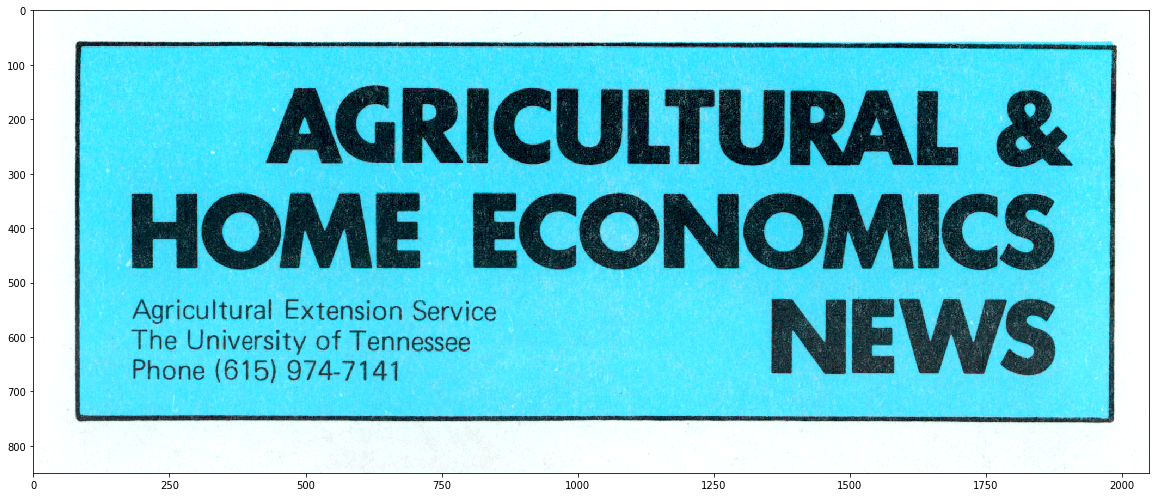

Processing Agricultural & home economics news_orange . . .


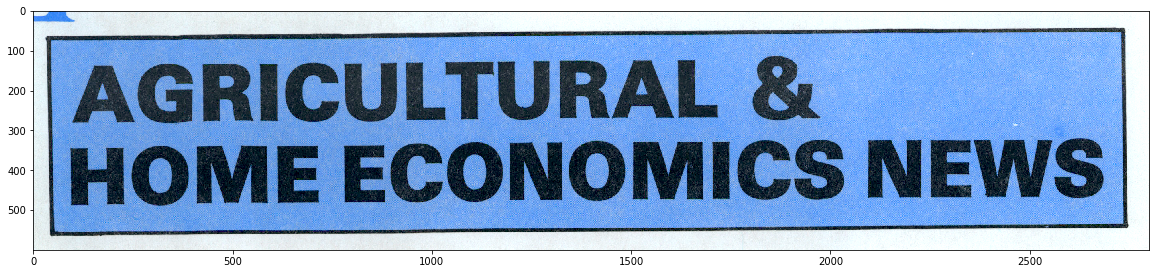

Processing Agricultural news . . .


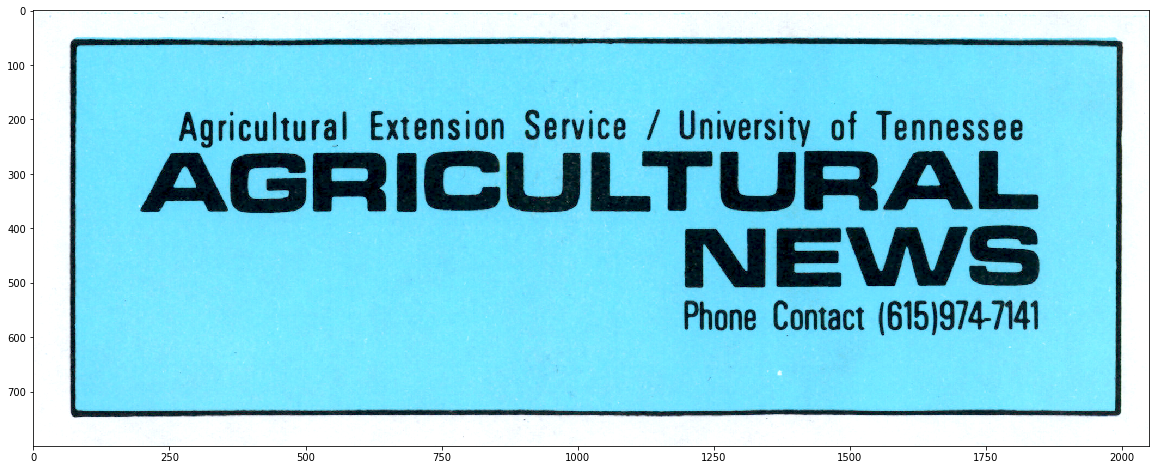

Processing Agricultural and home economics packet . . .


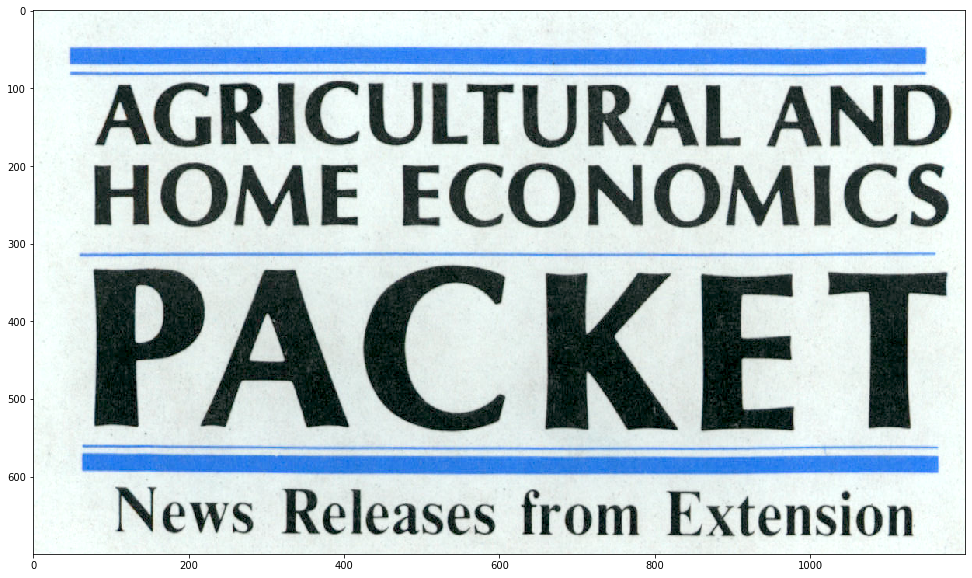

Processing Tennessee farm and home news . . .


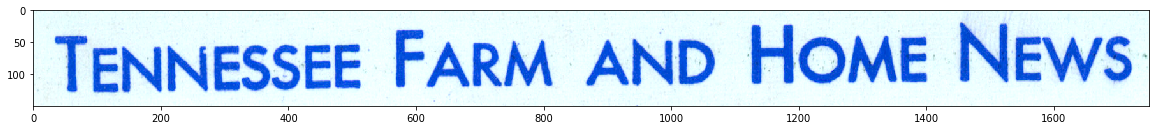

Processing Tennessee farm and home news_gray_early . . .


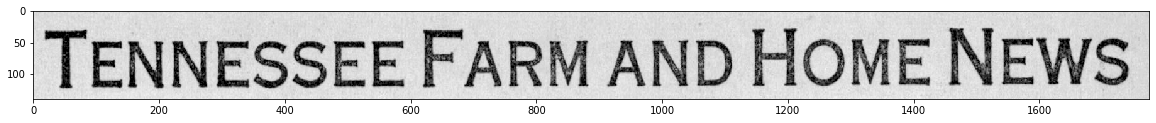

Processing Tennessee farm and home news_gray_late . . .


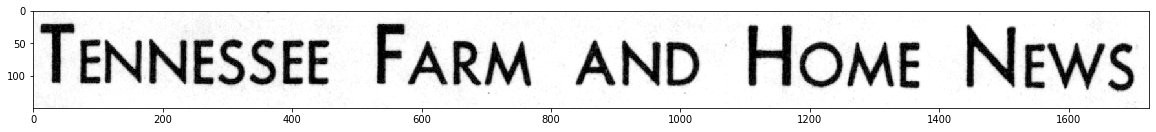

Processing Farm news . . .


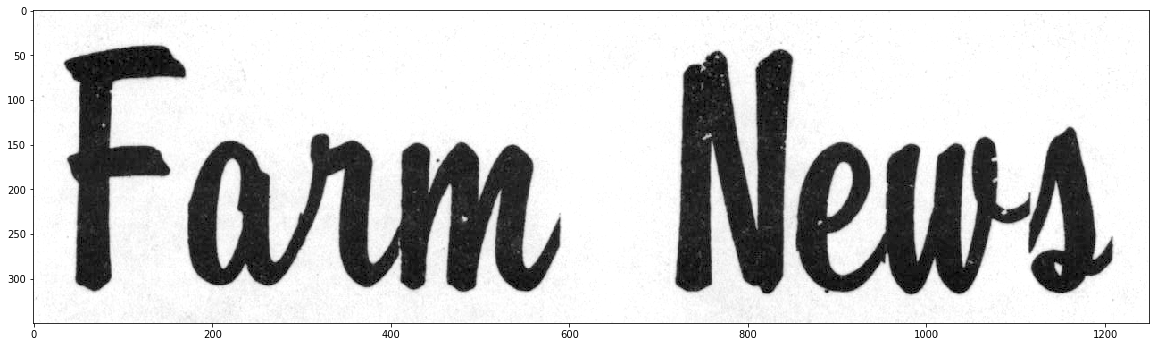

Processing Tennessee farm news_1 . . .


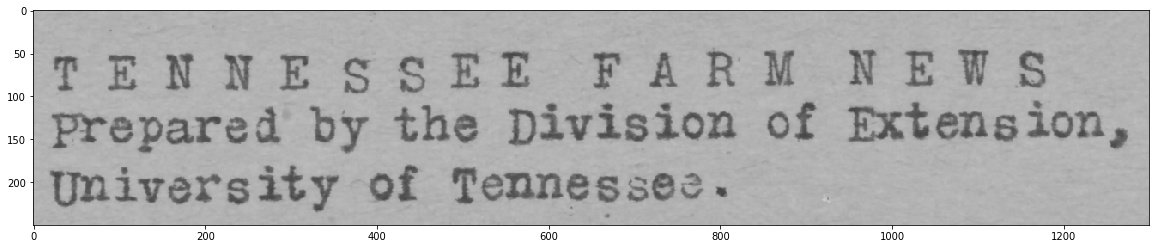

Processing Tennessee farm news_2 . . .


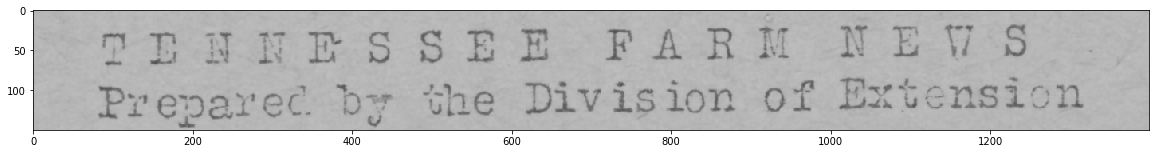

Processing Tennessee farm news_3 . . .


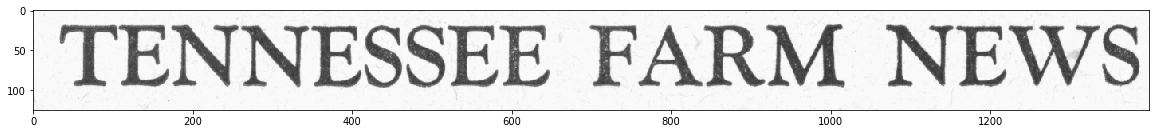

Processing Tennessee farm news_4 . . .


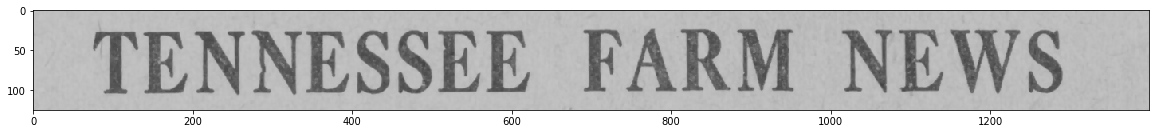

Processing Tennessee farm news_5 . . .


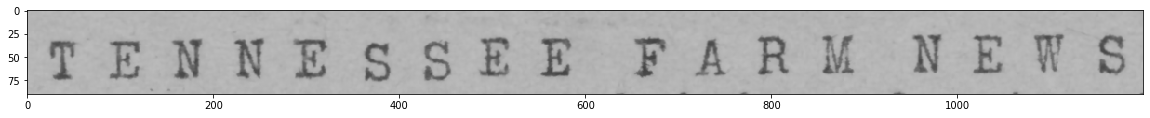


13 images in title crops dictionary


In [88]:
# create title crop dictionary

title_crops_dict = {}
bgr_title_crops_dict = {}
gray_title_crops_dict = {}

for title in title_crops_data_dict:
    
    print(f'Processing {title} . . .')
    
    # get image_path and it's crop box
    adminDB_ending = f'{title_crops_data_dict[title][0]}_0001.tif'
    image_path = [x for x in page_1_paths_list if x.name.endswith(adminDB_ending)][0]
    crop_box = title_crops_data_dict[title][1]
    
    # load image
    image_for_title_crop = cv2.imread(str(image_path))
    
    # convert PIL crop box to numpy values and crop image
    x1, y1, x2, y2 = crop_box
    title_crop = image_for_title_crop[y1:y2, x1:x2].copy()
    
    # add cropped image to dictionaries
    title_crops_dict.update( {title: title_crop} )
    image = Image.open(image_path)
    if image.mode == 'L':  # then Grayscale
        gray_title_crops_dict.update( {title: title_crop} )
        cmap = 'gray'
    else:  # then BGR
        bgr_title_crops_dict.update( {title: title_crop} )
        #title_crop = cv2.cvtColor(title_crop, cv2.COLOR_BGR2RGB)
        cmap = None
        
    plt.imshow(title_crop, cmap=cmap), plt.show()
    
print('')
print(f'{len(title_crops_dict)} images in title crops dictionary')
    

In [104]:
image_paths_list = page_1_paths_list[1000::250]
len(image_paths_list)

10

Begin: 0012_004266_001001_0001
        testing for: Tennessee farm and home news_gray_early
                   matches/minimum matches: 79/5
                   ssim: 0.6592777090188703
        testing for: Tennessee farm and home news_gray_late
                   matches/minimum matches: 0/5
        testing for: Farm news
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_1
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_2
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_3
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_4
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_5
                   matches/minimum matches: 0/5


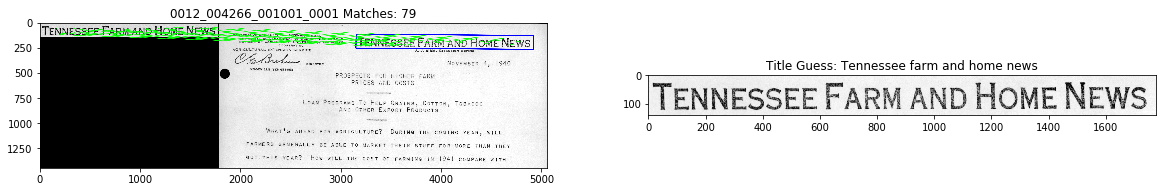


Begin: 0012_004266_001251_0001
        testing for: Tennessee farm and home news_gray_early
                   matches/minimum matches: 63/5
                   ssim: 0.5800337896942122
        testing for: Tennessee farm and home news_gray_late
                   matches/minimum matches: 7/5
                   ssim: 0.3872797667448919
        testing for: Farm news
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_1
                   matches/minimum matches: 2/5
        testing for: Tennessee farm news_2
                   matches/minimum matches: 3/5
        testing for: Tennessee farm news_3
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_4
                   matches/minimum matches: 2/5
        testing for: Tennessee farm news_5
                   matches/minimum matches: 2/5


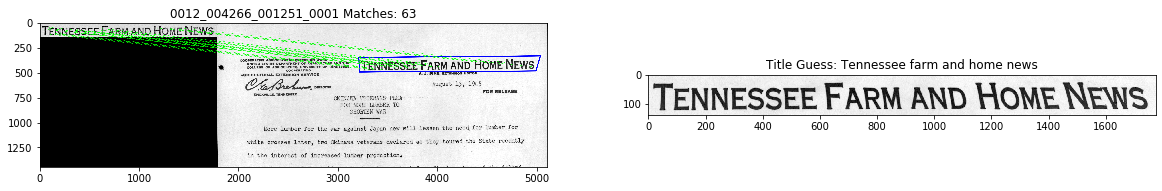


Begin: 0012_004266_001501_0001
        testing for: Tennessee farm and home news_gray_early
                   matches/minimum matches: 8/5
                   ssim: 0.37033119165072
        testing for: Tennessee farm and home news_gray_late
                   matches/minimum matches: 57/5
                   ssim: 0.607748957637995
        testing for: Farm news
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_1
                   matches/minimum matches: 6/5
                   ssim: 0.33203606783677453
        testing for: Tennessee farm news_2
                   matches/minimum matches: 3/5
        testing for: Tennessee farm news_3
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_4
                   matches/minimum matches: 3/5
        testing for: Tennessee farm news_5
                   matches/minimum matches: 3/5


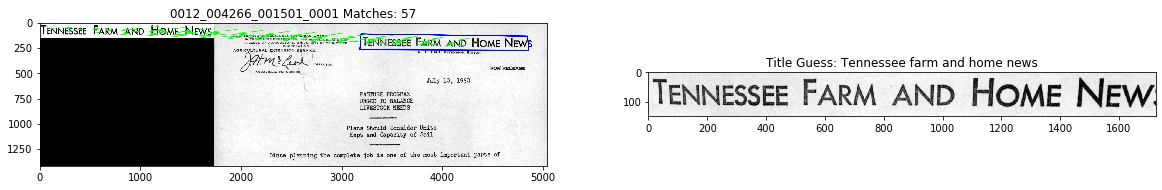


Begin: 0012_004266_001751_0001
        testing for: Tennessee farm and home news_gray_early
                   matches/minimum matches: 4/5
        testing for: Tennessee farm and home news_gray_late
                   matches/minimum matches: 45/5
                   ssim: 0.6412987097554219
        testing for: Farm news
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_1
                   matches/minimum matches: 5/5
        testing for: Tennessee farm news_2
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_3
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_4
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_5
                   matches/minimum matches: 3/5


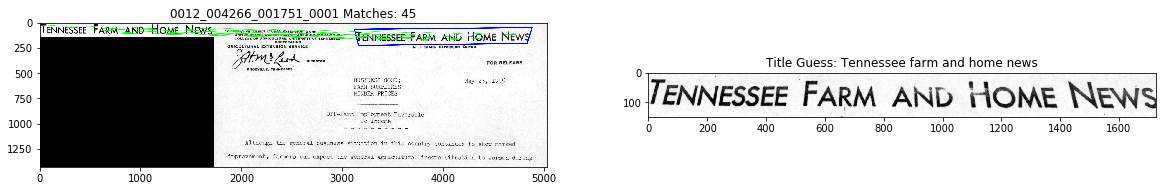


Begin: 0012_004266_002001_0001
        testing for: Tennessee farm and home news_gray_early
                   matches/minimum matches: 12/5
                   ssim: 0.3937472202245578
        testing for: Tennessee farm and home news_gray_late
                   matches/minimum matches: 55/5
                   ssim: 0.5822098670412451
        testing for: Farm news
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_1
                   matches/minimum matches: 2/5
        testing for: Tennessee farm news_2
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_3
                   matches/minimum matches: 2/5
        testing for: Tennessee farm news_4
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_5
                   matches/minimum matches: 0/5


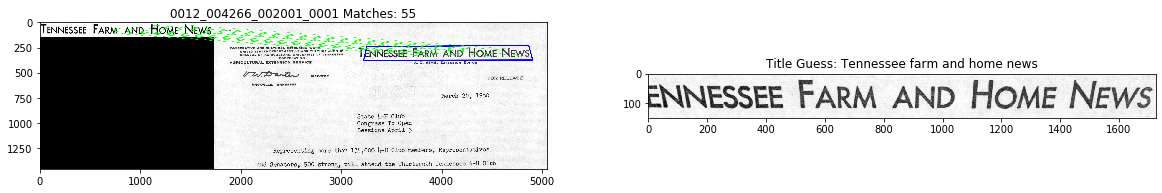


Begin: 0012_004266_002251_0001
        testing for: Tennessee farm and home news_gray_early
                   matches/minimum matches: 5/5
        testing for: Tennessee farm and home news_gray_late
                   matches/minimum matches: 8/5
                   ssim: 0.5393066641326054
        testing for: Farm news
                   matches/minimum matches: 77/5
                   ssim: 0.7564808160298825
        testing for: Tennessee farm news_1
                   matches/minimum matches: 3/5
        testing for: Tennessee farm news_2
                   matches/minimum matches: 3/5
        testing for: Tennessee farm news_3
                   matches/minimum matches: 1/5
        testing for: Tennessee farm news_4
                   matches/minimum matches: 3/5
        testing for: Tennessee farm news_5
                   matches/minimum matches: 6/5
                   ssim: 0.40116128326887157


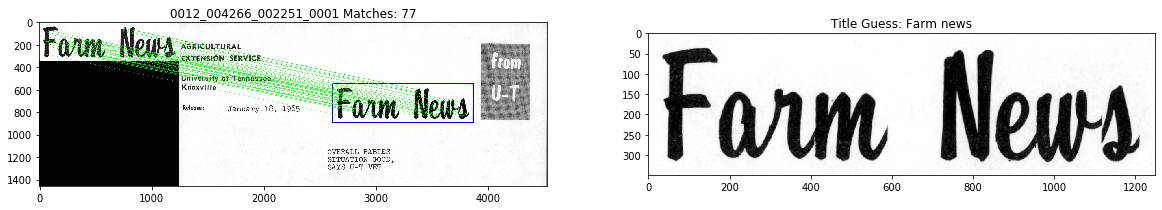


Begin: 0012_004266_002502_0001
        testing for: Tennessee farm and home news_gray_early
                   matches/minimum matches: 1/5
        testing for: Tennessee farm and home news_gray_late
                   matches/minimum matches: 12/5
                   ssim: 0.3320600192017286
        testing for: Farm news
                   matches/minimum matches: 73/5
                   ssim: 0.7746399528029994
        testing for: Tennessee farm news_1
                   matches/minimum matches: 4/5
        testing for: Tennessee farm news_2
                   matches/minimum matches: 2/5
        testing for: Tennessee farm news_3
                   matches/minimum matches: 0/5
        testing for: Tennessee farm news_4
                   matches/minimum matches: 3/5
        testing for: Tennessee farm news_5
                   matches/minimum matches: 3/5


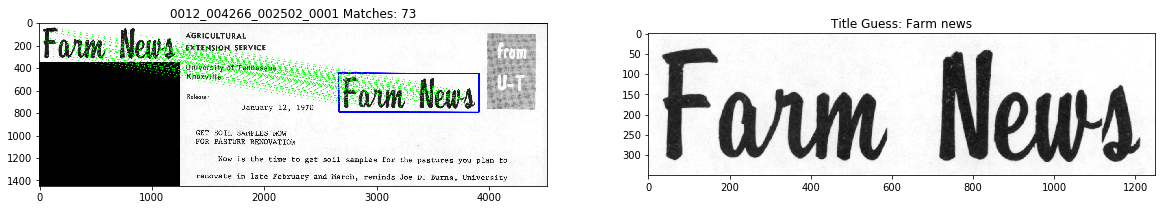


Begin: 0012_004266_002752_0001
        testing for: Agricultural & home economics news_yellow
                   matches/minimum matches: 246/40
                   ssim: 0.7990292443610036
        testing for: Agricultural & home economics news_orange
                   matches/minimum matches: 16/40
        testing for: Agricultural news
                   matches/minimum matches: 2/40
        testing for: Agricultural and home economics packet
                   matches/minimum matches: 0/40
        testing for: Tennessee farm and home news
                   matches/minimum matches: 3/40


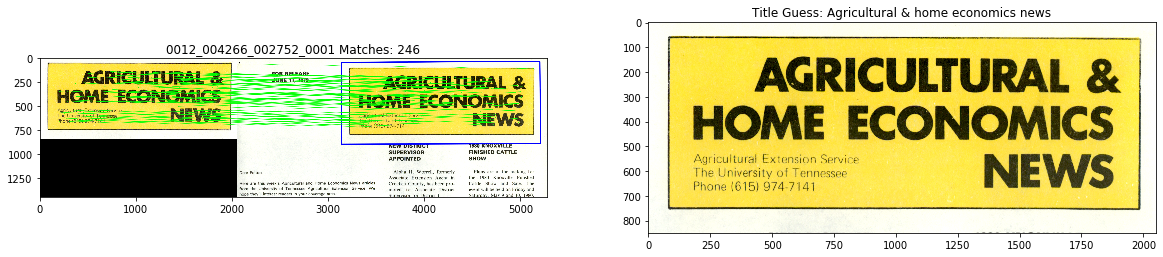


Begin: 0012_004266_003002_0001
        testing for: Agricultural & home economics news_yellow
                   matches/minimum matches: 12/40
        testing for: Agricultural & home economics news_orange
                   matches/minimum matches: 176/40
                   ssim: 0.4499422366951457
        testing for: Agricultural news
                   matches/minimum matches: 7/40
        testing for: Agricultural and home economics packet
                   matches/minimum matches: 10/40
        testing for: Tennessee farm and home news
                   matches/minimum matches: 7/40


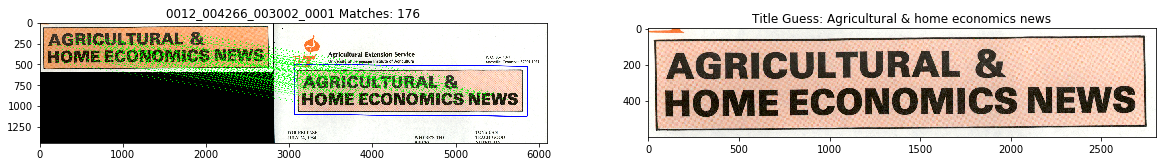


Begin: 0012_004266_003252_0001
        testing for: Agricultural & home economics news_yellow
                   matches/minimum matches: 9/40
        testing for: Agricultural & home economics news_orange
                   matches/minimum matches: 5/40
        testing for: Agricultural news
                   matches/minimum matches: 299/40
                   ssim: 0.7597319192243404
        testing for: Agricultural and home economics packet
                   matches/minimum matches: 0/40
        testing for: Tennessee farm and home news
                   matches/minimum matches: 2/40


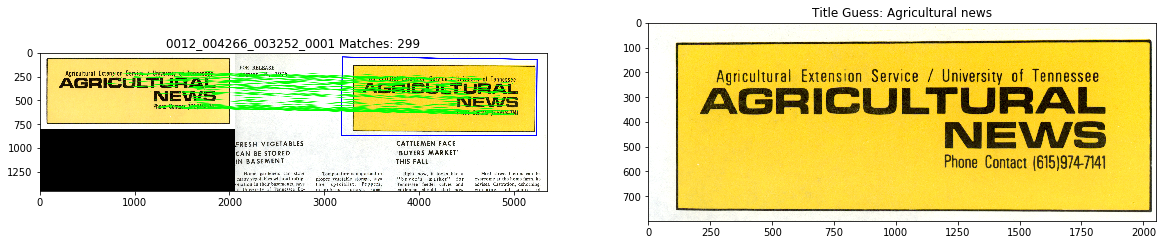

In [105]:
# identify titles!

# https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/17496530#17496530
rows_list = []

gray_minimum_matches = 5
gray_distance_ratio = 0.6
bgr_minimum_matches = 40
bgr_distance_ratio = 0.55

# progress bar
progress_label = Label('Images to process')
progress_bar = IntProgress(min=0, max=len(image_paths_list))
progress_widget = VBox([progress_label, progress_bar])
display(progress_widget)

number_of_no_good_matches = 0
number_found_match = 0

for index, image_path in enumerate(image_paths_list, start=1):
    
    label = f'Processing {image_path.name} . . . \r    {index}/{len(image_paths_list)}'
    progress_label.value = label
    
    print(f'Begin: {image_path.stem}')
    
    # load image and crop to top 1/3
    image = cv2.imread(str(image_path))
    height, width = image.shape[:2]
    image_cropped = image[0:(int(height/3)), 0:width].copy() # [y1:y2, x1:x2]
    # plt.imshow(image_cropped), plt.show()
    
    # set variables
    most_matches = 0
    best_matched_image = 0
    best_found_image = None
    best_title = None
    best_ssim_with_title = -1  # ssim varies from -1 to 1 (perfect match)
    best_match_value = 0
    
    # check if image is bgr or grayscale to get title dict to use
    with Image.open(image_path) as image:
        if image.mode == 'L':  # then Grayscale
            grayscale = True
            title_dict = gray_title_crops_dict
            minimum_matches = gray_minimum_matches
            distance_ratio = gray_distance_ratio
        else:
            grayscale = False
            title_dict = bgr_title_crops_dict
            minimum_matches = bgr_minimum_matches
            distance_ratio = bgr_distance_ratio
    
    for title in title_dict:
        title_crop = title_dict[title]
        
        print(f'        testing for: {title}')
        number_of_matches, matched_image, found_image = find_crop_rootSift(title_crop, image_cropped, minimum_matches, distance_ratio)
        print(f'                   matches/minimum matches: {number_of_matches}/{minimum_matches}')
        # plt.imshow(found_image), plt.show()
        if number_of_matches > minimum_matches:
            if found_image is not None:
                # get the structural similarity index of the match with the image for a 2nd heuristic    
                np_found = cv2.cvtColor(found_image, cv2.COLOR_BGR2GRAY)
                np_title_crop = cv2.cvtColor(np.array(title_crop), cv2.COLOR_BGR2GRAY)
                # print(f'np_found: {np_found.shape}')
                # print(f'np_title_crop: {np_title_crop.shape}')
                try:
                    ssim_with_title = ssim(np_title_crop, np_found, multichannel=True)
                    print(f'                   ssim: {ssim_with_title}')
                    if ssim_with_title > best_ssim_with_title:
                        best_ssim_with_title = ssim_with_title
                        most_matches = number_of_matches
                        best_matched_image = matched_image
                        best_found_image = found_image
                        best_title = title

                except ValueError:  # image shape doesn't match, so most likely incorrect title
                    continue

                if best_title == 'Agricultural & home economics news_orange' or best_title == 'Agricultural & home economics news_yellow':
                    best_title = 'Agricultural & home economics news'
                elif best_title == 'Tennessee farm and home news_gray_early' or best_title == 'Tennessee farm and home news_gray_late':
                    best_title = 'Tennessee farm and home news'

    if isinstance(best_matched_image, int):
        print('')
        print('     ***** No good match found *****')
        print('')
        number_of_no_good_matches += 1
        
    else:
        # convert to RGB channel order and show crop
        if len(best_matched_image.shape) > 2:
            best_matched_image = cv2.cvtColor(best_matched_image, cv2.COLOR_BGR2RGB)
            best_found_image = cv2.cvtColor(best_found_image, cv2.COLOR_BGR2RGB)
            cmap = None
        else:
            cmap = 'gray'
        # display images
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        axes[0].imshow(best_matched_image, cmap=cmap)
        axes[0].set_title(f'{image_path.stem} Matches: {most_matches}')
        axes[1].imshow(best_found_image, cmap=cmap)
        axes[1].set_title(f'Title Guess: {best_title}')
        plt.show()
        
        number_found_match += 1
        
        results_dictionary = {}
        # get input row in dictionary format
        # key = col_name
        results_dictionary.update( {'image_path': image_path} )
        results_dictionary.update( {'title_crop': best_found_image})
        results_dictionary.update( {'title_guess': best_title})
        
        rows_list.append(results_dictionary)
        
    progress_bar.value = index
    
    print('')

In [106]:
print(rows_listist)

[{'image_path': PosixPath('data/images/0012_004266_001001_0001.tif'), 'title_crop': array([[[240, 240, 240],
        [243, 243, 243],
        [244, 244, 244],
        ...,
        [239, 239, 239],
        [238, 238, 238],
        [241, 241, 241]],

       [[238, 238, 238],
        [245, 245, 245],
        [247, 247, 247],
        ...,
        [239, 239, 239],
        [239, 239, 239],
        [243, 243, 243]],

       [[236, 236, 236],
        [243, 243, 243],
        [245, 245, 245],
        ...,
        [244, 244, 244],
        [241, 241, 241],
        [245, 245, 245]],

       ...,

       [[237, 237, 237],
        [242, 242, 242],
        [241, 241, 241],
        ...,
        [245, 245, 245],
        [247, 247, 247],
        [246, 246, 246]],

       [[240, 240, 240],
        [243, 243, 243],
        [241, 241, 241],
        ...,
        [247, 247, 247],
        [249, 249, 249],
        [249, 249, 249]],

       [[243, 243, 243],
        [244, 244, 244],
        [240, 240, 240],
   

In [107]:
df = pd.DataFrame(rows_list)
df

image_path  \
0  data/images/0012_004266_001001_0001.tif   
1  data/images/0012_004266_001251_0001.tif   
2  data/images/0012_004266_001501_0001.tif   
3  data/images/0012_004266_001751_0001.tif   
4  data/images/0012_004266_002001_0001.tif   
5  data/images/0012_004266_002251_0001.tif   
6  data/images/0012_004266_002502_0001.tif   
7  data/images/0012_004266_002752_0001.tif   
8  data/images/0012_004266_003002_0001.tif   
9  data/images/0012_004266_003252_0001.tif   

                                          title_crop  \
0  [[[240, 240, 240], [243, 243, 243], [244, 244,...   
1  [[[239, 239, 239], [242, 242, 242], [245, 245,...   
2  [[[247, 247, 247], [246, 246, 246], [241, 241,...   
3  [[[249, 249, 249], [248, 248, 248], [247, 247,...   
4  [[[244, 244, 244], [245, 245, 245], [244, 244,...   
5  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
6  [[[251, 251, 251], [250, 250, 250], [252, 252,...   
7  [[[255, 255, 248], [255, 255, 247], [255, 255,...   
8  [[[255, 247, 241], [255, 254, 244], [255, 253,...   
9  [[[255, 255, 251], [255, 255, 250], [255, 255,...   

                          title_guess  
0        Tennessee farm and home news  
1        Tennessee farm and home news  
2        Tennessee farm and home news  
3        Tennessee farm and home news  
4        Tennessee farm and home news  
5                           Farm news  
6                           Farm news  
7  Agricultural & home economics news  
8  Agricultural & home economics news  
9                   Agricultural news

In [ ]:
image = cv2.imread(str(image_path))
number_of_good_matches, matched_graphic, found_image = find_crop(image)

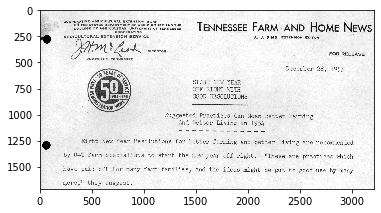

In [43]:
image = crop_image_for_ocr(image_path,
                           percentage=percentage,
                           top_and_sides_padding=top_and_sides_padding)
bgr_imshow(image)

## Return "canvas" without matches drawn on it, just the PolyLines so we can get the area drawn on original scan for verification of title guess